# 6. SMOTE Technique (Over-Sampling):
SMOTE stands for **Synthetic Minority Over-sampling Technique**. Unlike Random UnderSampling, SMOTE creates new synthetic points in order to have an equal balance of the classes. This is another alternative for solving the "class imbalance problems".

# What is SMOTE?

* SMOTE is an oversampling technique that generates synthetic samples from the dataset which increases the predictive power for minority classes. Even though there is no loss of information but it has a few limitations.

# Understanding SMOTE:
* Solving the Class Imbalance: SMOTE creates synthetic points from the minority class in order to reach an equal balance between the minority and majority class.

* Location of the synthetic points: SMOTE picks the distance between the closest neighbors of the minority class, in between these distances it creates synthetic points.

* Final Effect: More information is retained since we didn't have to delete any rows unlike in random undersampling.

* Accuracy || Time Tradeoff: Although it is likely that SMOTE will be more accurate than random under-sampling, it will take more time to train since no rows are eliminated as previously stated.

In [2]:
import warnings
warnings.simplefilter('ignore', (FutureWarning, DeprecationWarning))

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['savefig.dpi']=300
plt.rcParams['savefig.bbox'] ='tight'
np.set_printoptions(precision=3, suppress=True)
import pandas as pd
pd.set_option('precision', 3)
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import scale, StandardScaler

In [3]:
from sklearn.datasets import fetch_openml
data = fetch_openml('mammography')
X, y = data.data, data.target
y= (y.astype(np.int) + 1) // 2

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)

In [5]:
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [37]:
#print('Original scores : (0.9202523350276881, 0.6335760292641773)')
scores = cross_validate(LogisticRegression(),
                       X_train, y_train, cv=10, scoring=('roc_auc', 'average_precision'))

scores['test_roc_auc'].mean(), scores['test_average_precision'].mean()

(0.9202523350276881, 0.6335760292641773)

# SMOTE

In [14]:
from imblearn.over_sampling import SMOTE
smote = SMOTE()
X_train_smote, y_train_smote = smote.fit_sample(X_train, y_train)
print('original train', X_train.shape, y_train.shape)
print('X_train_sm0te', X_train_smote.shape)
print('original bincount: ',np.bincount(y_train))
print('smote bincount', np.bincount(y_train_smote))

original train (8387, 6) (8387,)
X_train_sm0te (16384, 6)
original bincount:  [8192  195]
smote bincount [8192 8192]


# Visualizing our original and applying SMOTE

In [15]:
rng = np.random.RandomState(0)
n_samples_1 = 1000
n_samples_2 = 100
X_syn = np.r_[1.5 * rng.randn(n_samples_1, 2),
        0.5 * rng.randn(n_samples_2, 2) + [2, 2]]
y_syn = np.array([0] * (n_samples_1) + [1] * (n_samples_2))
X_syn_train, X_syn_test, y_syn_train, y_syn_test = train_test_split(X_syn, y_syn)

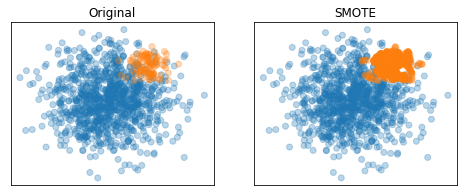

In [17]:
X_resampled, y_resampled = SMOTE().fit_sample(X_syn, y_syn)
fig, axes = plt.subplots(1,2,figsize = (8,3), subplot_kw={'xticks':(), 'yticks':()})
axes[0].scatter(X_syn[:, 0], X_syn[:, 1], c=plt.cm.tab10(y_syn), alpha=.3)
axes[1].scatter(X_resampled[:, 0], X_resampled[:,1], c =plt.cm.tab10(y_resampled), alpha =.3)
axes[0].set_title('Original')
axes[1].set_title('SMOTE')
plt.show()

Text(0.5, 1.0, 'SMOTE')

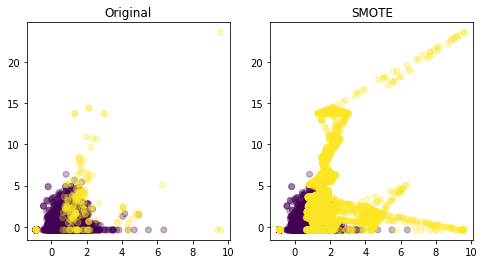

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
sorting = np.argsort(y_train)
axes[0].scatter(X_train[sorting, 3], X_train[sorting, 4], c=y_train[sorting], alpha=.3)
axes[1].scatter(X_train_smote[:, 3], X_train_smote[:, 4], c=y_train_smote, alpha=.3)
axes[0].set_title("Original")
axes[1].set_title("SMOTE")

In [19]:
np.bincount(y_train_smote)

array([8192, 8192], dtype=int64)

In [20]:
np.bincount(y_train)

array([8192,  195], dtype=int64)

In [24]:
# Building the SMote model on Reg
print('Original scores : (0.9202523350276881, 0.6335760292641773)')

from imblearn.pipeline import make_pipeline as make_imb_pipeline
smote_pipe= make_imb_pipeline(SMOTE(), LogisticRegression())
scores = cross_validate(smote_pipe, X_train, y_train, cv=10,
                       scoring=('roc_auc', 'average_precision'))
scores['test_roc_auc'].mean(), scores['test_average_precision'].mean()

Original scores : (0.9202523350276881, 0.6335760292641773)


(0.9189475565085322, 0.578847279218628)

In [25]:
# SMOTE ON RF
print('Original scores : (0.9202523350276881, 0.6335760292641773)')

smote_pipe_rf = make_imb_pipeline(SMOTE(), RandomForestClassifier(n_estimators=100))
scores = cross_validate(smote_pipe_rf, X_train, y_train, cv=10,
                        scoring=('roc_auc', 'average_precision'))
pd.DataFrame(scores)[['test_roc_auc', 'test_average_precision']].mean()

Original scores : (0.9202523350276881, 0.6335760292641773)


test_roc_auc              0.948
test_average_precision    0.696
dtype: float64

In [26]:
from sklearn.model_selection import GridSearchCV
param_grid = {'smote__k_neighbors': [3, 5, 7, 9, 11, 15, 31]}
search = GridSearchCV(smote_pipe_rf, param_grid, cv=10, return_train_score=True, scoring="average_precision")
search.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('smote', SMOTE()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier())]),
             param_grid={'smote__k_neighbors': [3, 5, 7, 9, 11, 15, 31]},
             return_train_score=True, scoring='average_precision')

In [27]:
search.best_score_

0.7023664141571011

Text(0, 0.5, 'Average Precision')

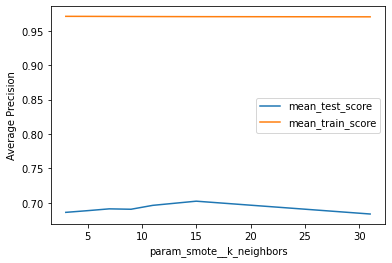

In [28]:
results = pd.DataFrame(search.cv_results_)
results.plot("param_smote__k_neighbors", ["mean_test_score", "mean_train_score"])
plt.ylabel("Average Precision")

In [31]:
print('Original scores : (0.9202523350276881, 0.6335760292641773)')

smote_pipe_rf = make_imb_pipeline(SMOTE(k_neighbors=15), RandomForestClassifier(n_estimators=100))
scores = cross_validate(smote_pipe_rf, X_train, y_train, cv=10, scoring=('roc_auc', 'average_precision'))
scores['test_roc_auc'].mean(), scores['test_average_precision'].mean()

Original scores : (0.9202523350276881, 0.6335760292641773)


(0.9503130559356491, 0.6978344943669972)